In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from matplotlib import pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
from distributed import Client
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics
plt.rcParams.update({'font.size': 15})

In [2]:
# !pip install fbprophet

## Load the data

In [3]:
data = pd.read_csv(r'C:\Users\magggien\Downloads\monthly_crimes_10_21.csv')
data.head()

,Month,Crime type,Violence and sexual offences,Public order,Anti-social behaviour,Burglary,Criminal damage and arson,Drugs,Bicycle theft,Violent crime,Possession of weapons,Public disorder and weapons,Other theft,Robbery,Other crime,Shoplifting,Vehicle crime,Theft from the person
0,2010-12,474341,NaN,NaN,201016,37893,NaN,NaN,NaN,57580.0,NaN,NaN,NaN,5731,142705,NaN,29416,NaN
1,2011-01,514641,NaN,NaN,201792,44388,NaN,NaN,NaN,59823.0,NaN,NaN,NaN,6667,167072,NaN,34899,NaN
2,2011-02,514329,NaN,NaN,206801,41821,NaN,NaN,NaN,56691.0,NaN,NaN,NaN,6480,168945,NaN,33591,NaN
3,2011-03,577983,NaN,NaN,241110,43777,NaN,NaN,NaN,62326.0,NaN,NaN,NaN,6558,189038,NaN,35174,NaN
4,2011-04,606409,NaN,NaN,277010,40062,NaN,NaN,NaN,64299.0,NaN,NaN,NaN,6275,185240,NaN,33523,NaN


In [4]:
# Make Month as a datetime form 
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format=True,errors='ignore')
df_total_crimes = data[['Month','Crime type']];
df_total_crimes.head()

,Month,Crime type
0,2010-12-01,474341
1,2011-01-01,514641
2,2011-02-01,514329
3,2011-03-01,577983
4,2011-04-01,606409


In [5]:
#take only the data from 2011 until 2019 and rename the columns
data_10_19 =df_total_crimes[1:109]
data_10_19 = data_10_19.rename(columns={'Month':'ds'})
data_10_19 = data_10_19.rename(columns={'Crime type':'y'})

In [6]:
data_10_19.head()

,ds,y
1,2011-01-01,514641
2,2011-02-01,514329
3,2011-03-01,577983
4,2011-04-01,606409
5,2011-05-01,587662


In [7]:
graph_data_training = data_10_19[0:96]
graph_data_training

,ds,y
1,2011-01-01,514641
2,2011-02-01,514329
3,2011-03-01,577983
4,2011-04-01,606409
5,2011-05-01,587662
...,...,...
92,2018-08-01,580732
93,2018-09-01,547800
94,2018-10-01,582858
95,2018-11-01,548308


C:\Users\magggien\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


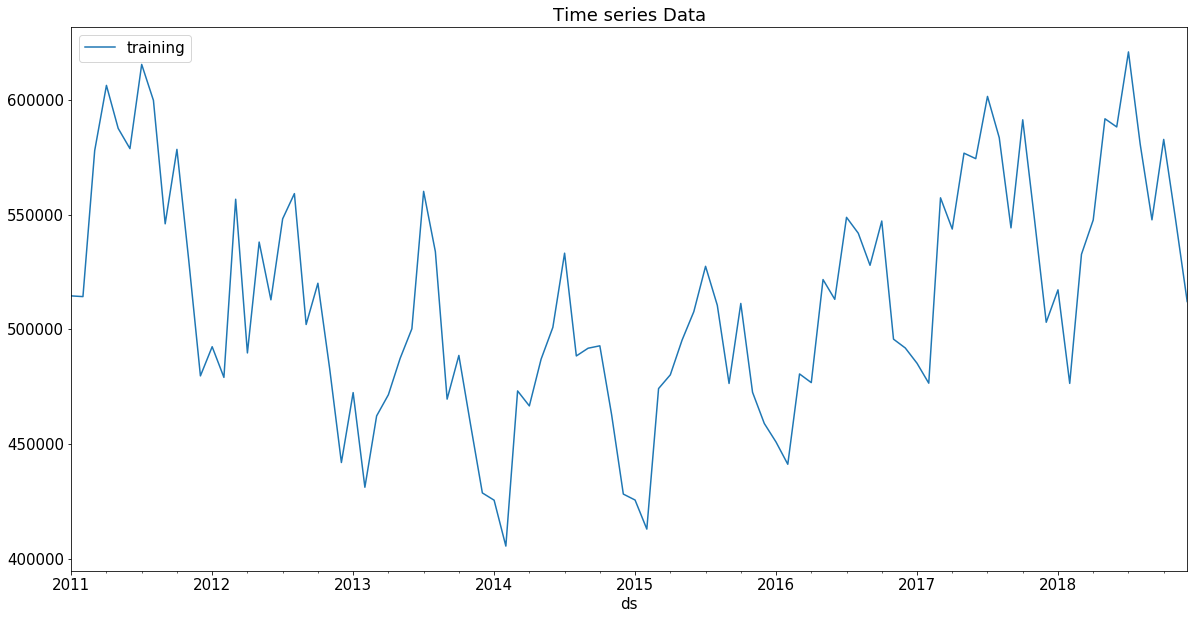

In [8]:
# plotting the time series data
graph_data_training['ds'] = pd.to_datetime(graph_data_training['ds'], format='%Y-%m-%d')
graph_data_training.plot(x='ds', y='y', figsize=(20, 10), title='Time series Data')
plt.legend(['training']);

## Prophet model initialization

In [9]:
#Building the model
m_19 = Prophet(seasonality_mode='multiplicative', yearly_seasonality = 11,interval_width=0.95).fit(data_10_19)
#Note that MS used here is month-start, meaning the data point is placed on the start of each month.
future = m_19.make_future_dataframe(periods=12, freq='MS')
fcst_19 = m_19.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Our group decided to exclude the Covid period from our forecasting model, because it would influence the model in a way that would result in more unrealistic predictions. We believe that's the case, because after 2021, in the UK everything started to return back to "normal". The year 2019 is more close to 2022 in this sense.

In [10]:
# Future predictions for 2022
fcst_19[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,531732.375801,505732.506091,555518.086699
1,2011-02-01,511562.464872,487661.627350,535277.924104
2,2011-03-01,575278.688875,552151.293694,599916.644278
3,2011-04-01,586440.979095,562822.707234,610951.563085
4,2011-05-01,591594.881838,568967.243104,617700.742355


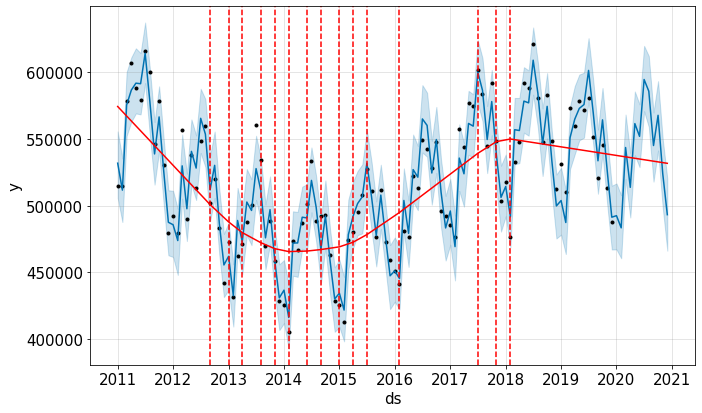

In [11]:
fig = m_19.plot(fcst_19)
# let's plot the changing points in the data
a = add_changepoints_to_plot(fig.gca(), m_19, fcst_19)

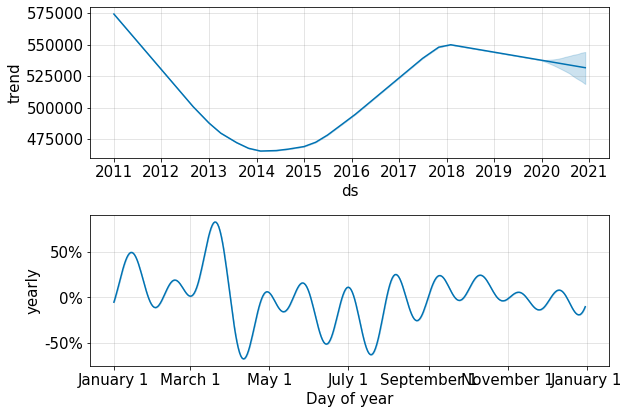

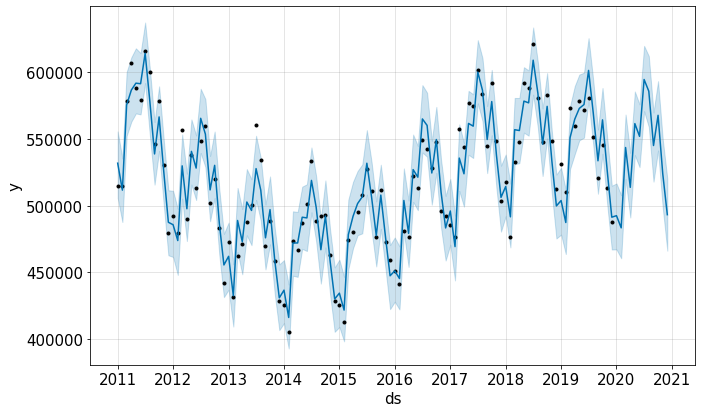

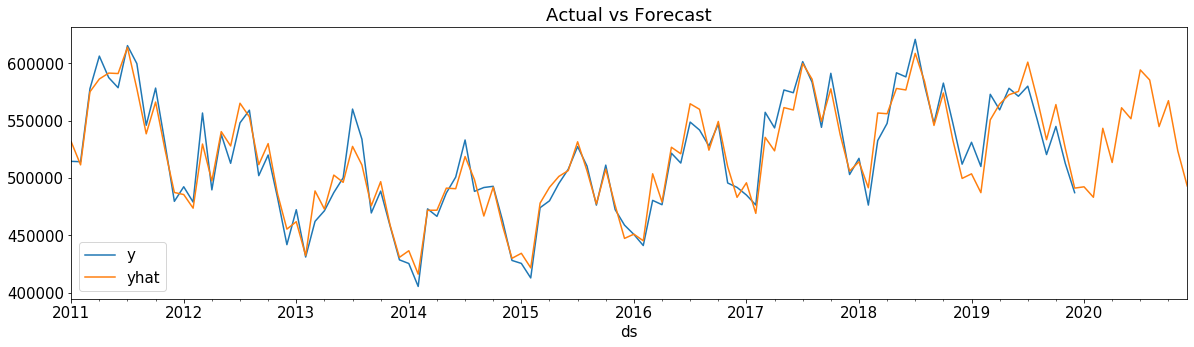

In [12]:
fig = m_19.plot_components(fcst_19)
fig = m_19.plot(fcst_19)
# plotting the actual and forecast values
ax = (data_10_19.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
fcst_19.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

### Dask library to make the code to run faster

In [13]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:65404 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 17.10 GB


## Evaluation of the model 

### Cross Validation

The initial model will be trained using 2555 days of data. It will forecast the next 365 days of data (since the horizon is set to 365 days). In this case, the model will train on the initial period + the period (2555 + 182.5 days) and forecast the next 365 days. So, the process will continue, adding another 182.5 days to the training data and then forecasting for the next 365 until there is no more data to do so.

In [14]:
df_cv_19 = cross_validation(m_19, initial='2555 days', period='182.5 days', horizon = '365 days',parallel="dask")
df_p = performance_metrics(df_cv_19)


INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-01 12:00:00 and 2018-12-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:65404' processes=4 threads=12, memory=17.10 GB>


In [15]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days 00:00:00,1.733282e+08,13165.418314,13091.468749,0.023051,0.023051,1.0
1,60 days 12:00:00,6.399552e+08,25297.336346,23598.630624,0.041797,0.041797,0.5
2,62 days 00:00:00,5.664437e+08,23800.077004,20318.167807,0.035931,0.035931,0.5
3,90 days 00:00:00,5.809286e+07,7621.867125,7615.626869,0.014141,0.014141,1.0
4,91 days 12:00:00,3.830774e+08,19572.362180,17002.402810,0.030743,0.030743,0.5
5,121 days 00:00:00,8.889771e+08,29815.718589,29667.436402,0.053532,0.053532,0.0
6,121 days 12:00:00,8.371748e+08,28933.972681,28659.189456,0.050337,0.050337,0.0
7,151 days 00:00:00,5.058666e+08,22491.478390,22372.710942,0.038518,0.038518,0.5
8,152 days 12:00:00,3.396853e+08,18430.552267,18350.711338,0.032517,0.032517,1.0
9,182 days 00:00:00,7.706608e+08,27760.777912,26098.640167,0.046288,0.046288,0.5


In [16]:
rmse = df_p['rmse'].sum()/len(df_p)  
print("The average RMSE is ", rmse)

The average RMSE is  33770.28723432147


### Hyperparameter tuning


In [17]:
#Here parameters are evaluated on RMSE averaged over a 182.5 days.
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data_10_19)  # Fit model with given params
    df_cv_19 = cross_validation(m, initial='2555 days', period='182.5 days', horizon = '365 days',parallel="dask")
    df_p = performance_metrics(df_cv_19, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-01 12:00:00 and 2018-12-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:65404' processes=4 threads=12, memory=17.10 GB>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-01 12:00:00 and 2018-12-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:65404' processes=4 threads=12, memory=17.10 GB>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet 

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  40280.774428
1                     0.001                     0.10  37939.957115
2                     0.001                     1.00  38693.357695
3                     0.001                    10.00  39367.860902
4                     0.010                     0.01  38505.424994
5                     0.010                     0.10  44237.759951
6                     0.010                     1.00  38595.005693
7                     0.010                    10.00  45609.259165
8                     0.100                     0.01  32090.884413
9                     0.100                     0.10  31245.718729
10                    0.100                     1.00  31118.486771
11                    0.100                    10.00  30998.699293
12                    0.500                     0.01  23016.168706
13                    0.500                     0.10  23125.55

## Building the best model

According to the hypertuning, model 12 has the lowest RMSE of 23016.168706 when the seasonality prior scale and the changepoint prior scale are set to 0.01 and 0.5, respectively. It is for this reason that we set the parameters of our model with these numbers. 

In [18]:
#Building the model
m_19 = Prophet(changepoint_prior_scale=0.5,seasonality_prior_scale=0.01,seasonality_mode='multiplicative', yearly_seasonality = 11,interval_width=0.95).fit(data_10_19)
#Note that MS used here is month-start, meaning the data point is placed on the start of each month.
future = m_19.make_future_dataframe(periods=12, freq='MS')
fcst_19 = m_19.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
predicted_19 = fcst_19[96:108]
test_19 =  data_10_19[96:]

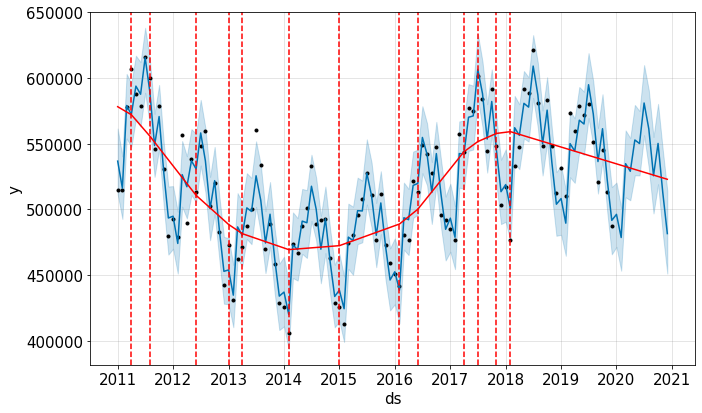

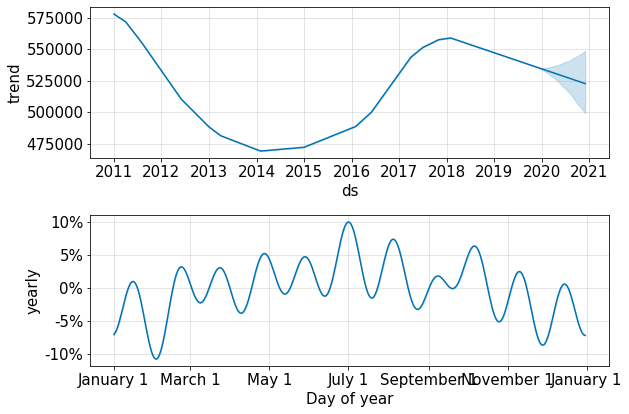

In [20]:
fig = m_19.plot(fcst_19)
# let's plot the changing points in the data
a = add_changepoints_to_plot(fig.gca(), m_19, fcst_19)
fig_trend = m_19.plot_components(fcst_19)
fig_trend.savefig('Prophet_trend_yearly.png');

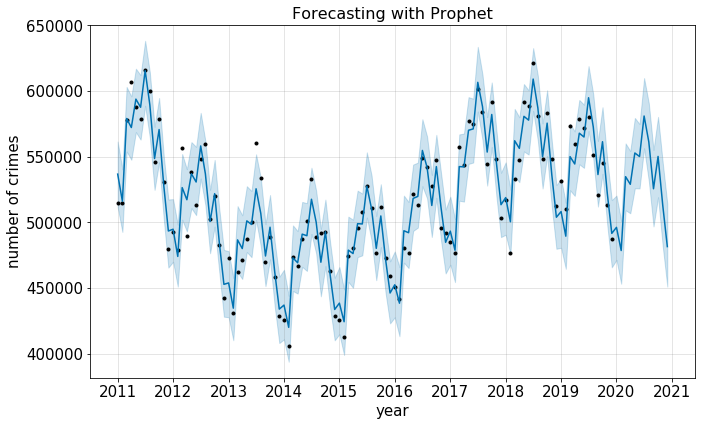

In [21]:
fig_forecast = m_19.plot(fcst_19)
plt.xlabel('year')
plt.ylabel('number of crimes')
plt.title('Forecasting with Prophet',fontsize = 16);
fig_forecast.savefig('forecasting_prophet_1.png')

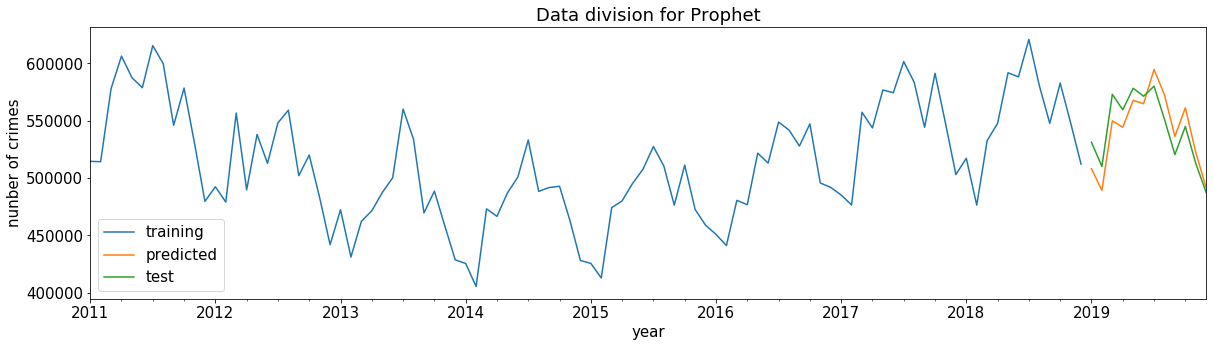

In [22]:
# plotting the actual and forecast values
ax = (graph_data_training.plot(x='ds',y='y',figsize=(20,5)))
predicted_19.plot(x='ds',y='yhat',figsize=(20,5), ax=ax)
test_19.plot(x='ds', y='y', figsize=(20, 5), title='Data division for Prophet', ax=ax)
ax.legend(['training','predicted','test'])
ax.set_xlabel('year');
ax.set_ylabel('nunber of crimes');
ax.figure.savefig("data_division_1.png")

In [23]:
df_cv_19 = cross_validation(m_19, initial='2555 days', period='182.5 days', horizon = '365 days',parallel="dask")
df_p = performance_metrics(df_cv_19)


INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-01 12:00:00 and 2018-12-01 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:65404' processes=4 threads=12, memory=17.10 GB>


In [24]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,31 days 00:00:00,1.276613e+08,11298.730448,7996.432824,0.015050,0.015050,1.0
1,60 days 12:00:00,4.245064e+08,20603.552986,20172.286946,0.036017,0.036017,0.5
2,62 days 00:00:00,3.801869e+08,19498.382284,18638.178440,0.033632,0.033632,0.5
3,90 days 00:00:00,1.599554e+08,12647.346191,12644.547626,0.023453,0.023453,1.0
4,91 days 12:00:00,2.718631e+08,16488.270646,16069.772311,0.028836,0.028836,1.0
5,121 days 00:00:00,1.976987e+08,14060.537421,10987.157066,0.020014,0.020014,1.0
6,121 days 12:00:00,7.996695e+07,8942.424205,7332.294396,0.012659,0.012659,1.0
7,151 days 00:00:00,9.228588e+07,9606.554114,8943.030639,0.015380,0.015380,1.0
8,152 days 12:00:00,3.438734e+07,5864.071945,5849.393508,0.010411,0.010411,1.0
9,182 days 00:00:00,8.587804e+07,9267.040498,8887.841582,0.015785,0.015785,1.0


In [25]:
rmse = df_p['rmse'].sum()/len(df_p)  
print("The average RMSE is ", rmse)


The average RMSE is  21278.966142669542


From https://www.statology.org/how-to-interpret-rmse/ :

'The RMSE represents the square root of the variance of the residuals.

This is a useful value to know because it gives us an idea of the average distance between the observed data values and the predicted data values.'

C:\Users\magggien\anaconda3\lib\site-packages\fbprophet\plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\magggien\anaconda3\lib\site-packages\fbprophet\plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


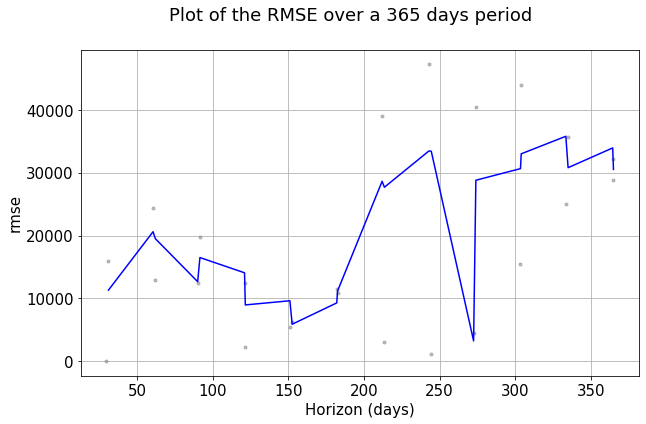

In [26]:
fig = plot_cross_validation_metric(df_cv_19, metric='rmse')
fig.suptitle('Plot of the RMSE over a 365 days period');

With this plot we can see the variance, change in the RMSE over a 365 days period. 